In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import zscore

**You might get lost from here on. So, we decided to provide you with sections.**  
&emsp;1) [Load Data](#loaddata)  
&emsp;2) [Quick Clean-Up for EDA](#firstcleanup)  
&emsp;3) [Analyze Data and EDA](#eda)  
&emsp;4) [Create Preprocessing Pipeline](#prepro)  
&emsp;5) [Analysis Methods](#modelling)  
&emsp;6) [Ethical Considerations](#ethics)

# 1) Load Data <a name="loaddata"></a>

In [3]:
df = pd.read_csv('adult_reconstruction.csv')
df

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,65,35,0,0,Private,Bachelors,13,Married-civ-spouse,Husband,White,Male,Yugoslavia,85080,Farming-fishing
49527,77,37,3137,0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Vietnam,34137,Sales
49528,55,24,0,0,Private,Assoc-voc,11,Never-married,Not-in-family,White,Male,United-States,13016,Sales
49529,40,24,0,0,Private,Some-college,10,Never-married,Not-in-family,White,Female,United-States,15000,Adm-clerical


# 2) Quick Clean-Up for EDA <a name="firstcleanup"></a>

#### Fix missing values

In [4]:
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### There are some cells with ? in it, so we replace with nans and check the percentage of missing values.

In [5]:
df.isin(['?']).sum()

hours-per-week       0
age                  0
capital-gain         0
capital-loss         0
workclass         2859
education            0
education-num        0
marital-status       0
relationship         0
race                 0
gender               0
native-country     859
income               0
occupation        2869
dtype: int64

In [6]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)


In [7]:
perc1 = df['workclass'].isnull().sum()/len(df['workclass'])*100
perc2 = df['occupation'].isnull().sum()/len(df['occupation'])*100
perc3 = df['native-country'].isnull().sum()/len(df['native-country'])*100
print("Missing =", perc1,"% in 'workclass',", perc2,"% in 'occupation',", perc3,"% in 'native-country'")


Missing = 5.7721426985120425 % in 'workclass', 5.792332074862207 % in 'occupation', 1.7342674284791342 % in 'native-country'


In [8]:
lenBefore = df['workclass']
df.dropna(how='any', inplace=True)
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

In [9]:
## Check if there are any duplicate rows
df.duplicated().sum()

208

In [10]:
df = df.drop_duplicates()

In [11]:
#Encode the occupations into numbers for the plot below
dictt = dict()
count = 1
for k in list(set(list(df['occupation']))):
    dictt[k]=count
    count+=1
print(dictt)

newdf = df.copy()
for d in dictt:
    newdf=newdf.replace(d, dictt[d])

{'Armed-Forces': 1, 'Other-service': 2, 'Transport-moving': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Craft-repair': 6, 'Sales': 7, 'Machine-op-inspct': 8, 'Adm-clerical': 9, 'Prof-specialty': 10, 'Protective-serv': 11, 'Tech-support': 12, 'Exec-managerial': 13, 'Priv-house-serv': 14}


### Check for Outliers

[Text(0.5, 1.0, 'Histogram Plot of People Working for Different Hours per Week')]

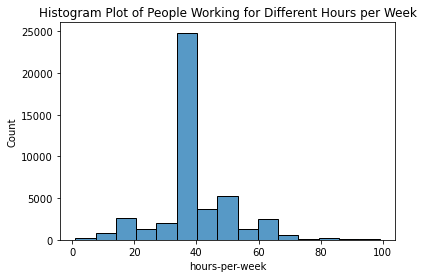

In [12]:
sns.histplot(df['hours-per-week'], bins = 15).set(title = 'Histogram Plot of People Working for Different Hours per Week')

99497.03015075377


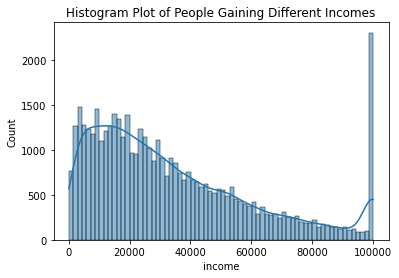

In [13]:
ax = sns.histplot(df['income'], bins=70, kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

ax.set(title = 'Histogram Plot of People Gaining Different Incomes')
##The last bin to remove
print(xs[-2])

[Text(0.5, 1.0, 'Histogram of Different Ages')]

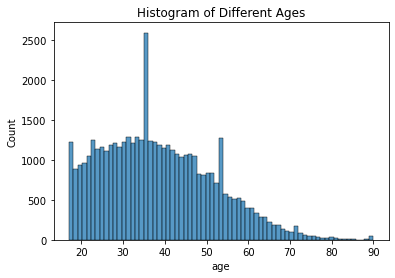

In [14]:
sns.histplot(df['age']).set(title='Histogram of Different Ages')

[Text(0.5, 1.0, 'Count of People with Different Education')]

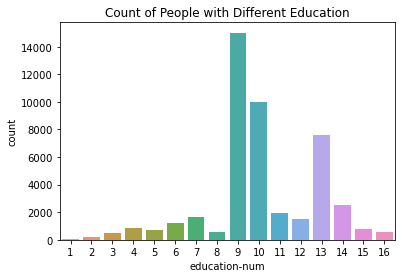

In [15]:
sns.countplot(df['education-num']).set(title='Count of People with Different Education')

[Text(0.5, 1.0, 'Histogram of Capital Gain')]

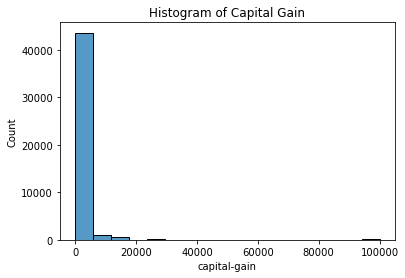

In [16]:
sns.histplot(df['capital-gain']).set(title='Histogram of Capital Gain')

[Text(0.5, 1.0, 'Histogram of Capital Loss')]

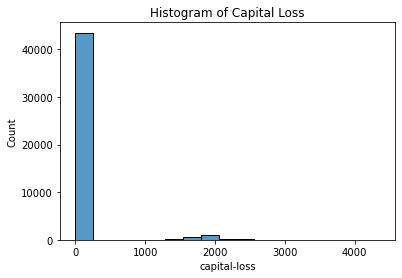

In [17]:
sns.histplot(df['capital-loss']).set(title='Histogram of Capital Loss')

We decided to remove the datatpoints, which are greater than the mean by 3 standard deviations, for the hours-per-week.
We also found that the last bin from the histogram of the income (bin 70) does not follow the distribution so we have removed all data points with income greater than 99497.

In [18]:
def remove_outliers_sd(data, variable):
    return data.loc[(np.abs(stats.zscore(data[variable])) < 3)]

def remove_outliers_bound(data, variable, lower=-np.inf, upper=np.inf):
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

In [19]:
df = remove_outliers_sd(df, 'hours-per-week')
df = remove_outliers_bound(df, 'income',upper = 99497)

# 3) Analyze Data & EDA <a name="eda"></a>

&emsp;1) [Is there a relationship between sex/race/age and income?](#1)  
&emsp;2) [Is a certain sex/race preferred in a certain occupation given the same education levels?](#2)  
&emsp;3) [Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week?](#3)  
&emsp;4) [How are the occupation types distributed over the genders?](#4) 


#### Create dummy variables _for the plots only for now_

[Text(0.5, 1.0, 'Histogram of Age')]

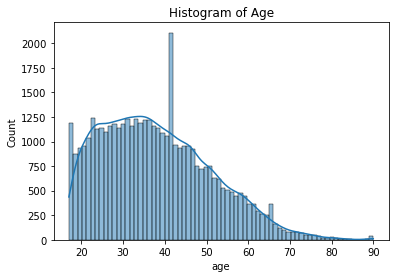

In [20]:
sns.histplot(df['age'], bins=70, kde=True).set(title = 'Histogram of Age')

Since we have ages from 17 to 90, we need to group them so we can plot it with income. We have a lot of 17 and 40 years olds. So, we suggest this grouping:  
Group 1: <=20  
Group 2: >20 and <40  
Group 3: >= 40 and <65 (average retiring age)  
Group 4: >= 65

In [21]:
temp = []
for i in df['age']:
    if i <= 20:
        temp.append("Group 1")
    if (i>20) and (i<40):
        temp.append("Group 2")
    if (i>=40) and (i<65):
        temp.append("Group 3")
    if (i>=65):
        temp.append("Group 4")
        
copiedDF = df.copy()
copiedDF['Grouped Ages'] = temp

### 3.1) Is there a relationship between sex/race/age and income? <a name="1"></a>

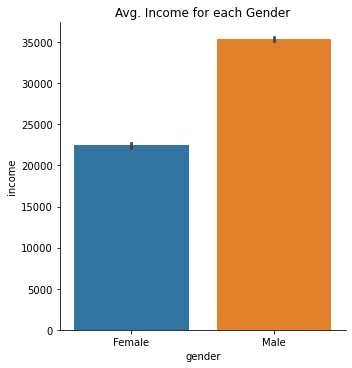

In [22]:
sns.catplot(data=df, kind="bar", x="gender", y="income").set(title='Avg. Income for each Gender')

Text(0.5, 1.0, 'Avg. Income for each Race')

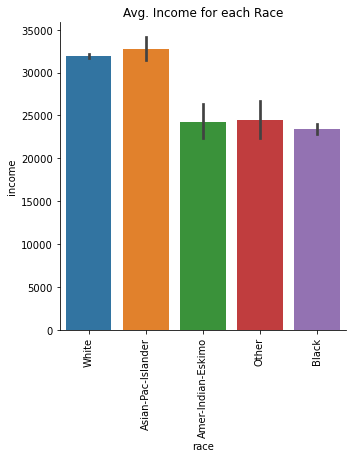

In [23]:
# 'Amer-Indian-Eskimo': 1,   'Asian-Pac-Islander': 2,   'Black': 3,   'Other': 4,   'White': 5
sns.catplot(data=df, kind="bar", x="race", y="income")
plt.xticks(rotation=90)
plt.title('Avg. Income for each Race')

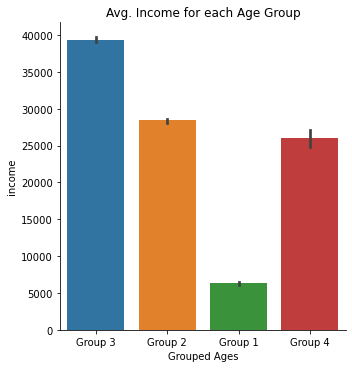

In [24]:
sns.catplot(data=copiedDF, kind="bar", x="Grouped Ages", y="income").set(title='Avg. Income for each Age Group')

### 3.2) Is a certain sex preferred in a certain occupation given the same education levels? <a name="2"></a>

Text(0.5, 1.0, 'Education Level Counts for the Tech-support Occupation')

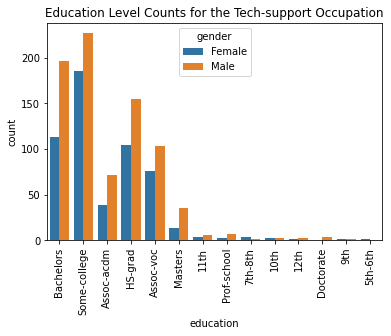

In [25]:
# '7th-8th': 1,   '1st-4th': 2,   'Some-college': 3,   '11th': 4,   '5th-6th': 5,   'Masters': 6,   'Preschool': 7, 
# 'Assoc-voc': 8,   'Bachelors': 9,   'HS-grad': 10,   '10th': 11,   'Doctorate': 12,   '12th': 13,   'Prof-school': 14,
# '9th': 15,   'Assoc-acdm': 16
sns.countplot(data=df.loc[df['occupation']=='Tech-support'], x='education', hue='gender')
plt.xticks(rotation=90)
plt.title('Education Level Counts for the Tech-support Occupation')

In [26]:
# If you wanna see another occupation
column_values = df[["occupation"]].values.ravel()
unique_values =  pd.unique(column_values)
unique_values

array(['Tech-support', 'Craft-repair', 'Other-service', 'Sales',
       'Exec-managerial', 'Handlers-cleaners', 'Machine-op-inspct',
       'Prof-specialty', 'Adm-clerical', 'Farming-fishing',
       'Transport-moving', 'Priv-house-serv', 'Protective-serv',
       'Armed-Forces'], dtype=object)

### 3.3) Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week? <a name="3"></a>

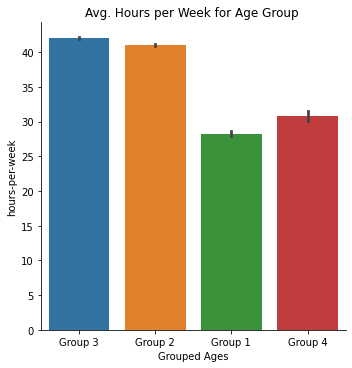

In [27]:
sns.catplot(data=copiedDF, kind="bar", x="Grouped Ages", y="hours-per-week").set(title='Avg. Hours per Week for Age Group ')

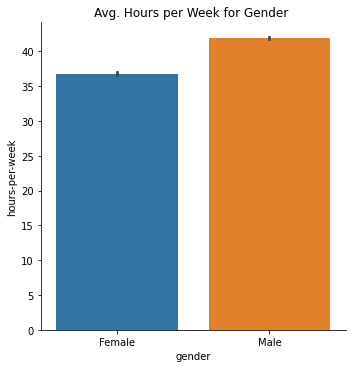

In [28]:
sns.catplot(data=df, kind="bar", x="gender", y="hours-per-week").set(title='Avg. Hours per Week for Gender ')

Text(0.5, 1.0, 'Avg. Hours per Week for each Race')

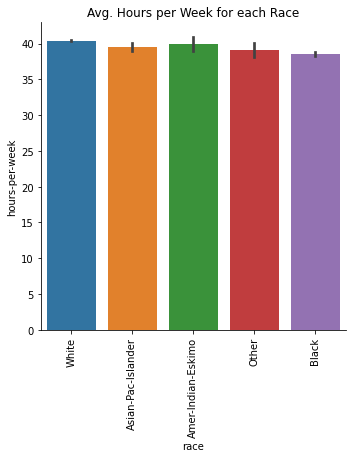

In [29]:
# 'Amer-Indian-Eskimo': 1,   'Asian-Pac-Islander': 2,   'Black': 3,   'Other': 4,   'White': 5
sns.catplot(data=df, kind="bar", x="race", y="hours-per-week")
plt.xticks(rotation=90)
plt.title('Avg. Hours per Week for each Race')

Text(0.5, 1.0, 'Avg. Hours per Week for each Marital-Status')

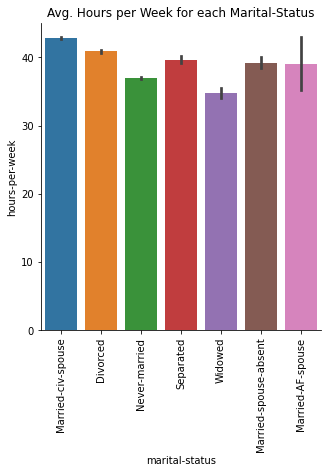

In [30]:
# 'Married-spouse-absent': 1,   'Separated': 2,   'Widowed': 3,   'Divorced': 4,   'Never-married': 5,  
# 'Married-AF-spouse': 6,   'Married-civ-spouse': 7
sns.catplot(data=df, kind="bar", x="marital-status", y="hours-per-week")
plt.xticks(rotation=90)
plt.title('Avg. Hours per Week for each Marital-Status')

### 3.4) How are the occupation types distributed over the genders? <a name="4"></a>

[Text(0.5, 1.0, 'Avg. Number of Gender in Tech Support')]

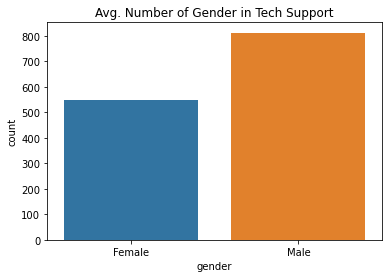

In [31]:
# Adm-clerical': 1,   'Armed-Forces': 2,   'Transport-moving': 3,   'Tech-support': 4,   'Handlers-cleaners': 5,
# 'Exec-managerial': 6,   'Machine-op-inspct': 7,   'Prof-specialty': 8,   'Protective-serv': 9,   'Other-service': 10,
# 'Sales': 11,   'Craft-repair': 12,   'Priv-house-serv': 13,   'Farming-fishing': 14
sns.countplot(data=copiedDF.loc[df['occupation']=='Tech-support'], x='gender').set(title='Avg. Number of Gender in Tech Support')

# -------------------------------------------------------------------------------------

In [32]:
print(df.shape)
df.describe()

(42773, 14)


,hours-per-week,age,capital-gain,capital-loss,education-num,income
count,42773.000000,42773.000000,42773.000000,42773.000000,42773.000000,42773.000000
mean,40.196993,38.014028,355.083300,75.127978,9.968695,31028.398125
std,10.620301,13.166329,1590.412657,369.585186,2.482573,22901.242434
min,6.000000,17.000000,0.000000,0.000000,1.000000,107.000000
25%,40.000000,27.000000,0.000000,0.000000,9.000000,12780.000000
50%,40.000000,36.000000,0.000000,0.000000,10.000000,25520.000000
75%,45.000000,47.000000,0.000000,0.000000,12.000000,45070.000000
max,76.000000,90.000000,41310.000000,4356.000000,16.000000,99442.000000


Text(0.5, 1.0, 'Bar Plot of Gender vs Income for Each Occupation')

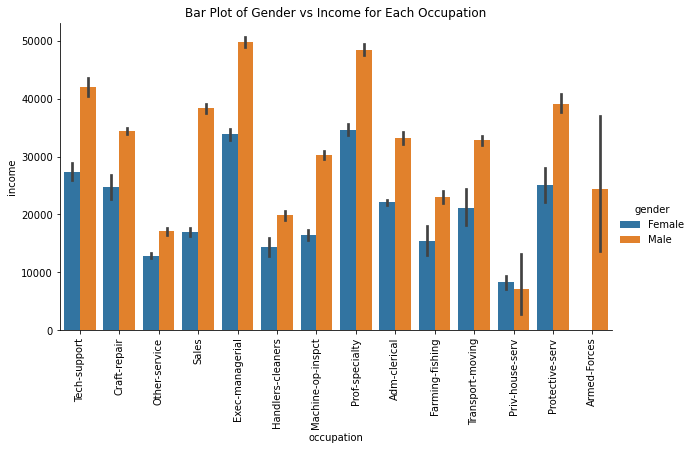

In [33]:
## cat plot of occupation and gender
## we need to show the x label better maybe with numbers
sns.catplot(data=df, kind="bar", x="occupation", y="income", hue="gender", aspect=14/8)
plt.xticks(rotation=90)
plt.title('Bar Plot of Gender vs Income for Each Occupation')

Text(0.5, 1.0, 'Bar Plot of Gender vs Hours-per-week for Each Occupation')

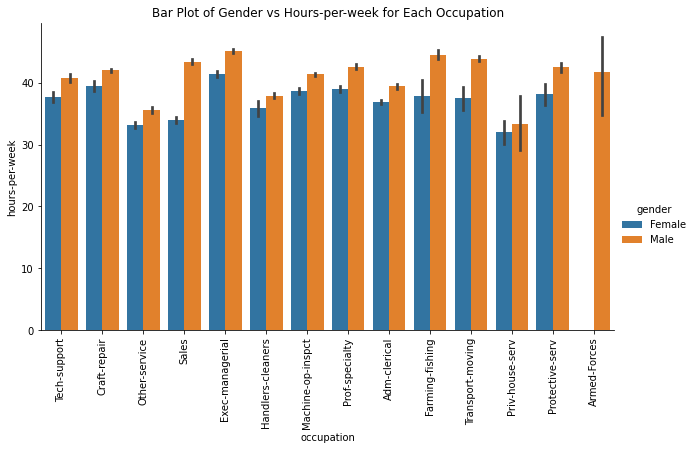

In [34]:
## cat plot of hours and gender
# We can see that men usually work more. To better visualize this, a histplot has been contstructed below
sns.catplot(data=df, kind="bar", x="occupation", y="hours-per-week", hue="gender", aspect=14/8)
plt.xticks(rotation=90)
plt.title('Bar Plot of Gender vs Hours-per-week for Each Occupation')

##### Let's check for which categorical data feature engineering is worth it

In [88]:
def drawPlot(xName):

    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=xName,
        y='income',
        data=df.sort_values(xName),
        ax=axs[0]
    )

    sns.countplot(
        x=xName,
        data=df.sort_values(xName),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=df['income'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)
    fig.suptitle('Plot of the Income of the People from each '+xName,fontsize = 16)

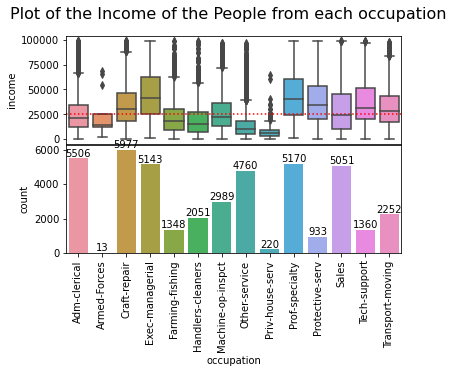

In [89]:
drawPlot("occupation")

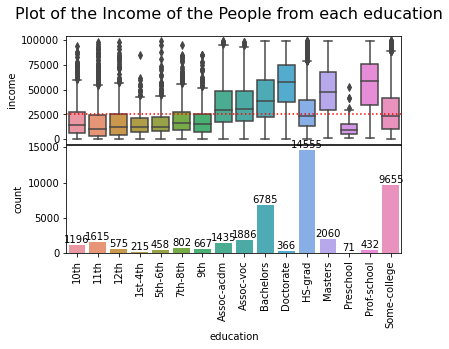

In [90]:
drawPlot("education")

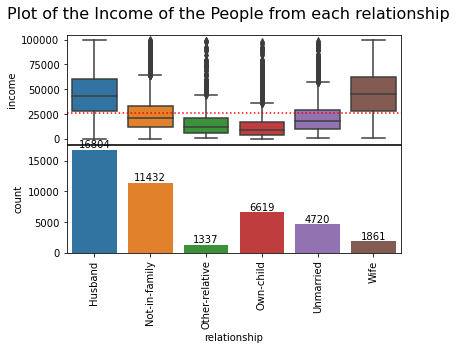

In [91]:
drawPlot("relationship")

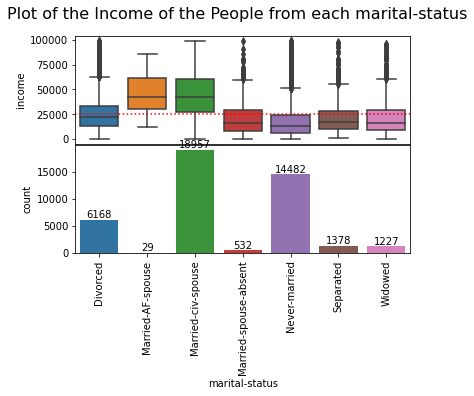

In [92]:
drawPlot("marital-status")

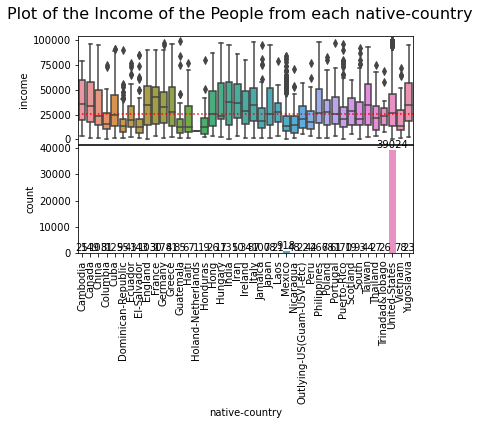

In [93]:
# Very biased, so no feature engineering on this feature
drawPlot("native-country")

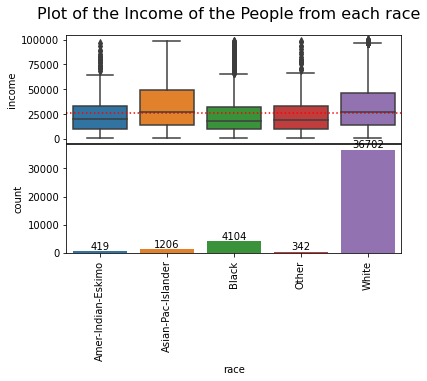

In [94]:
# Very biased, so no feature engineering on this feature as well as not on gender
drawPlot("race")

In [42]:
# Are the 0's in capital-gain and capital-loss missing values or indeed 0?

# 4) Create The Preprocessing Pipeline <a name="prepro"></a>

In [43]:
def select_columns(data, *columns):
    all_columns = []

    for val in data.columns:
        if val.startswith(columns):
            all_columns.append(val)

    return data.reindex(columns = all_columns)

In [44]:
def standardize_columns(data,epsilon=1e-100):
    standardized_data = (data - np.mean(data))/(np.std(data) + epsilon)
    return standardized_data

In [45]:
def rmse(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    # Normalized RMSE
    return rmse/(max(actual)-min(actual))

###### Create function for dummy values for all categorical data

In [46]:
def oheCategoricalData(data):
    to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
    dummy_vars = pd.get_dummies(data[to_drop])
    data = pd.concat([data.drop(to_drop, axis=1), dummy_vars], axis = 1)
    return data


###### Create functions for feature engineering

In [47]:
def find_highIncome(xName, data, n=3, metric=np.median ):
    return data.groupby(xName).agg(metric).sort_values(by=["income"],ascending=False).iloc[:n].index.values.tolist()

def add_in_highIncome(data, highIncome, xName):
    data["in_rich_"+xName] = 0
    mask = data[xName].isin(highIncome)
    data.loc[mask,"in_rich_"+xName] = 1
    return data, "in_rich_"+xName

In [48]:
def process_data(data):
    # Drop NaNs and duplicates
    data['workclass'] = data['workclass'].replace('?', np.nan)
    data['occupation'] = data['occupation'].replace('?', np.nan)
    data['native-country'] = data['native-country'].replace('?', np.nan)
    data.dropna(how='any', inplace=True)
    data = data.drop_duplicates()
    
    # Feature Engineering
    rich_Occupation = find_highIncome('occupation', data, n=3, metric=np.median )
    data, richOccs = add_in_highIncome(data, rich_Occupation, 'occupation')
    
    rich_Education = find_highIncome('education', data, n=3, metric=np.median )
    data, richEds = add_in_highIncome(data, rich_Education, 'education')

    rich_rel = find_highIncome('relationship', data, n=3, metric=np.median )
    data, richRels = add_in_highIncome(data, rich_rel, 'relationship')

    rich_MS = find_highIncome('marital-status', data, n=1, metric=np.median )
    data, richMS = add_in_highIncome(data, rich_MS, 'marital-status')
    
    # Create dummy variables for categorical    
    data = oheCategoricalData(data)



    data = (
        data
        # Clean Data
        .pipe(remove_outliers_sd, 'hours-per-week') # (681 outliers)
        .pipe(remove_outliers_bound, 'income', upper = 99497 ) 

        # Transform data
        .pipe(select_columns, 
              'age',                                 
              'education-num', 
              'workclass',
              'hours-per-week',
              'income',
              richOccs,
              richEds,
              richMS,

             )
    ) 
    
    # X = standardize_columns(data).drop(['income'], axis = 1)
    X = data.drop(['income'], axis = 1)
    y = data['income']
    
    return X, y

# 5) Analysis Methods <a name="modelling"></a>

5. Can we predict if the yearly income of a person is above 50k dollars or lower with logistic regression and decision trees?
6. Which machine learning model performs better in terms of RMSE (for Q5)?


In [49]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(main_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

/var/folders/yk/j071n21n4hx934n3wqzwtsyh0000gn/T/ipykernel_46469/2539868690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["in_rich_"+xName] = 0
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Lasso Model

In [50]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("Normalized RMSE Train: ", train_score, "Normalized RMSE Test: ", test_score)

Normalized RMSE Train:  0.17129834465131408 Normalized RMSE Test:  0.17600750146048014


### Comparing Plots of Test and Predicted Income Values Based on Gender

In [51]:
test_copy = X_test.copy()
test_copy = pd.concat([X_test, y_test], axis = 1)
test_copy['prediction'] = y_predicted_test

test_copy['gender'] = df[df.index.isin(test_copy.index)]['gender']
test_copy['occupation'] = df[df.index.isin(test_copy.index)]['occupation']

[Text(0.5, 1.0, 'Histogram of Different Actual Incomes')]

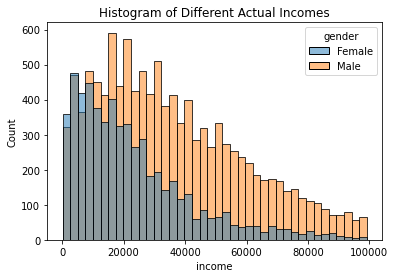

In [52]:
sns.histplot(data=test_copy, x='income', hue="gender").set(title = 'Histogram of Different Actual Incomes')

[Text(0.5, 1.0, 'Histogram of Different Predicted')]

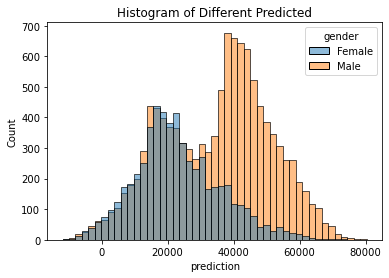

In [53]:
sns.histplot(data=test_copy, x='prediction', hue="gender").set(title='Histogram of Different Predicted')

## Create a model using data where the number of males and female for each occupation is equal

### newDATA is the data where the number males and females working in an occupation is made to be equal

In [54]:
listCounts=dict()
newDATA = pd.DataFrame()
for d in dictt:
    
    occupation = dictt[d]
    temp = newdf[newdf['occupation']==occupation]
    
    male = temp[temp['gender']=='Male']
    female = temp[temp['gender']=='Female']
    
    countMale = len(male)
    countFemale = len(female)
    
    listCounts[occupation] = [countMale, countFemale]
    
    #find the minimum then which gender is the min
    minn = min(listCounts[occupation])
    gender = listCounts[occupation].index(minn) ## if 0 then male, if 1 then female
    
    diff = abs(countMale-countFemale)
    
    if gender==0: ## then females need to be removed
        female= female.drop(female.index[len(female)-diff:len(female)], inplace=False)
    else:
        male = male.drop(male.index[len(male)-diff:len(male)], inplace=False)

    newDATA = pd.concat([newDATA, female], axis=0)
    newDATA = pd.concat([newDATA, male], axis=0)

In [55]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(newDATA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

#### Lasso Model

In [56]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("Normalized RMSE Train: ", train_score, "Normalized RMSE Test: ", test_score)

Normalized RMSE Train:  0.16395716042776748 Normalized RMSE Test:  0.1663311559483802


In [57]:
test_copy = X_test.copy()
test_copy = pd.concat([X_test, y_test], axis = 1)
test_copy['prediction'] = y_predicted_test

test_copy['gender'] = df[df.index.isin(test_copy.index)]['gender']
test_copy['occupation'] = df[df.index.isin(test_copy.index)]['occupation']

### Comparing Plots of Test and Predicted Income Values Based on Gender

[Text(0.5, 1.0, 'Histogram of Different Actual Incomes')]

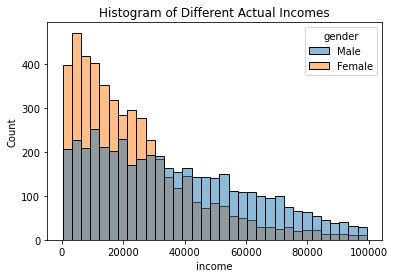

In [58]:
sns.histplot(data=test_copy, x='income', hue="gender").set(title = 'Histogram of Different Actual Incomes')

[Text(0.5, 1.0, 'Histogram of Different Predicted')]

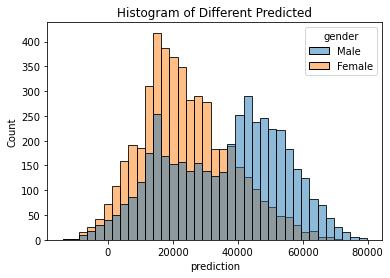

In [59]:
sns.histplot(data=test_copy, x='prediction', hue="gender").set(title='Histogram of Different Predicted')

# Ethical Considerations <a name="ethics"></a>